In [ ]:
import sys
sys.path.append('..')
from gptcast.models import VAEGANVQ
from gptcast.data import MiaradDataModule
from gptcast.utils.plotting import plot_mutiple
from gptcast.utils.converters import dbz_to_rainfall
import numpy as np
from datetime import datetime
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
from einops import rearrange

## Load pretrained model and a radar sequence of data from the dataset

In [ ]:
ae_old = VAEGANVQ.load_from_zenodo("vae_mae", device=device).eval()
ae_new = VAEGANVQ.load_from_zenodo("vae_mwae", device=device).eval()

In [ ]:
md = MiaradDataModule.load_from_zenodo(
    clip_and_normalize=[0,60,0,60],
    crop=None,
    batch_size=1,
    num_workers=1,
    pin_memory=False,
    seq_len=7,
)
md.setup(stage="test")
tdl = md.test_dataloader()
itr = iter(tdl)
el = next(itr)

In [10]:
dt = datetime.strptime(el['file_path_'][0], 'COMP_%Y%m%d%H%M')
mask = el['mask'].cpu().numpy().squeeze()
data = rearrange(el['image'].cpu().numpy().squeeze(), 'h w s -> s h w')
input_data = np.ma.array(data, mask=np.broadcast_to(mask, data.shape))

## Reconstruct the input sequence with both autencoders and compare the results

In [12]:
new_rec = ae_new.reconstruct(input_data, units='dbz')
old_rec = ae_old.reconstruct(input_data, units='dbz')

Working with z of shape torch.Size([7, 8, 19, 24]) = 25536 dimensions.
Working with z of shape torch.Size([7, 4, 19, 24]) = 12768 dimensions.


### plot input, new and old autoencoder output

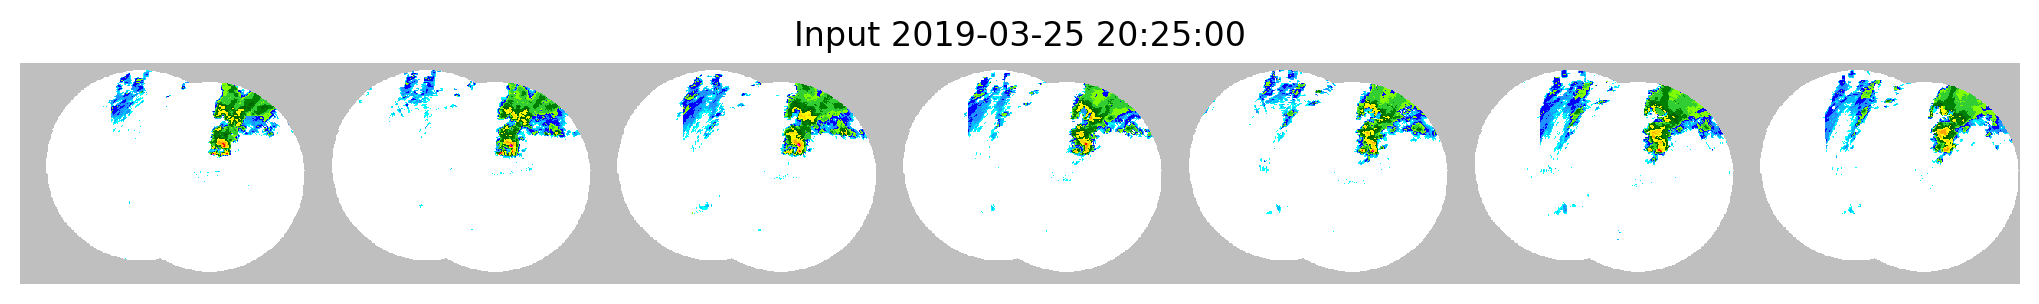

<Figure size 640x480 with 0 Axes>

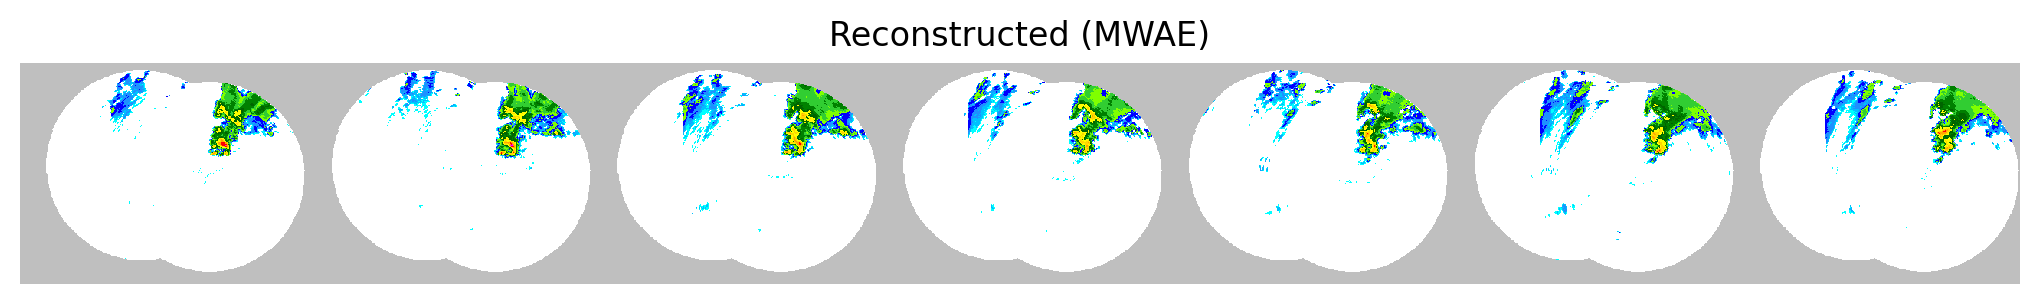

<Figure size 640x480 with 0 Axes>

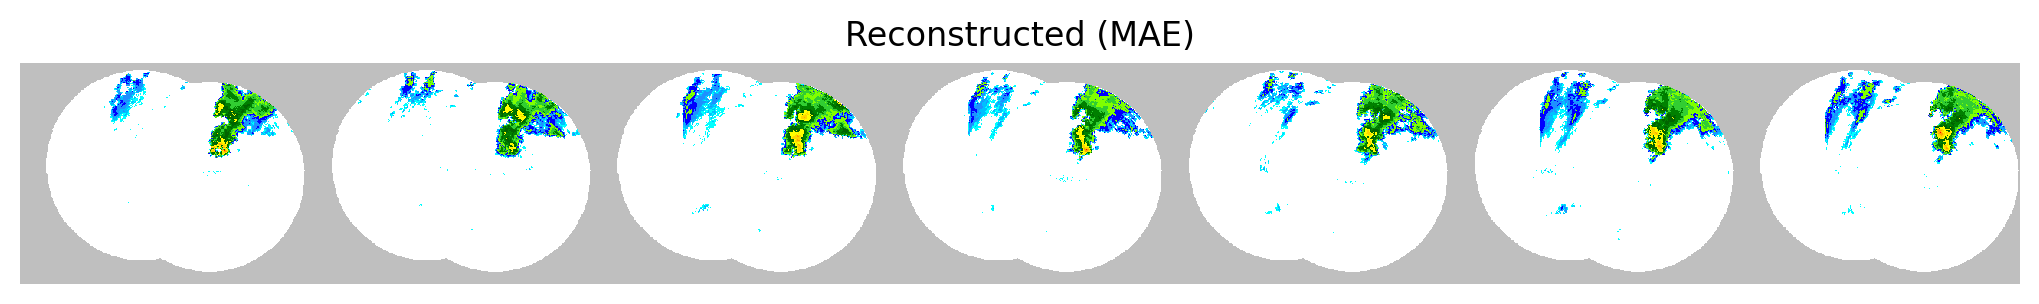

<Figure size 640x480 with 0 Axes>

In [13]:
plot_mutiple(dbz_to_rainfall(input_data), title=f"Input {dt}", figsize=(10,3))
plot_mutiple(dbz_to_rainfall(new_rec), title=f"Reconstructed (MWAE)", figsize=(10,3))
plot_mutiple(dbz_to_rainfall(old_rec), title=f"Reconstructed (MAE)", figsize=(10,3))